In [13]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

In [41]:
def explained_variance(X,xt):
    x_v=np.var(a=X,axis=0)
    Var_x=np.sum(x_v)
    xt_v=np.var(a=xt,axis=0)
    Exp_var=xt_v/Var_x
    print('Explained variance of each feature is: ', Exp_var)

In [14]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DT # Import Decision Tree Classifier
from sklearn.naive_bayes import GaussianNB as nbc
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, make_scorer
from sklearn.model_selection import (train_test_split, learning_curve, cross_val_score, cross_val_predict, 
ShuffleSplit, KFold, cross_validate)
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier as MLP

In [15]:
df = pd.read_csv("Datasets/D1.csv")
print("shape of the dataset", df.shape)

shape of the dataset (17499, 355)


In [27]:
def get_dataset():
    X = df.iloc[:, :-1]
    y = df.iloc[: , -1]
    return X, y

X,y=get_dataset()
print(X.shape,y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_test.shape,y_test.shape)

(17499, 354) (17499,)
(7000, 354) (7000,)


In [58]:
[xs,E]=sammon(X_test,110,maxiter=20)

epoch = 1 : E = 0.0000719886
epoch = 2 : E = 0.0000719813
epoch = 3 : E = 0.0000716362
epoch = 4 : E = 0.0000714215
epoch = 5 : E = 0.0000717758
epoch = 6 : E = 0.0000717131


KeyboardInterrupt: 

In [52]:
# explained variance of each feature
explained_variance(X_test,xs)

Explained variance of each feature is:  [1.74375475e-01 3.44609771e-01 1.41679359e-01 7.48614107e-02
 5.90930988e-02 4.32328588e-02 2.55060499e-02 2.04151501e-02
 1.85270278e-02 1.30172293e-02 1.16297655e-02 1.01721551e-02
 8.43298662e-03 6.20751797e-03 5.84770570e-03 4.43472422e-03
 4.05909769e-03 3.46831087e-03 2.91597567e-03 2.23538126e-03
 2.13315033e-03 2.00518657e-03 1.80234886e-03 1.64449067e-03
 1.45274844e-03 1.27808346e-03 9.67420342e-04 8.96820123e-04
 8.51602777e-04 7.58635814e-04 6.99926706e-04 6.76081641e-04
 6.44386657e-04 5.71610030e-04 4.77592594e-04 4.36622248e-04
 3.42043683e-04 2.90868637e-04 2.58047013e-04 2.52965906e-04
 2.43271304e-04 2.22225825e-04 2.02104624e-04 1.86379492e-04
 1.85786179e-04 1.70431254e-04 1.61396714e-04 1.53401514e-04
 1.29260242e-04 1.27535633e-04 1.22135636e-04 1.12675057e-04
 1.09464509e-04 1.05164423e-04 1.02348177e-04 1.00077041e-04
 9.69526711e-05 9.49771557e-05 9.17604889e-05 8.96732165e-05
 8.85055591e-05 8.59697056e-05 8.39932020e-05

In [53]:
def get_model():
    models = list()
    models.append(nbc())
    #models.append(make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear')))
#     models.append(DT())
#     models.append(MLP(hidden_layer_sizes=(256,128), activation='relu', solver='adam', alpha=0.005, max_iter=100, shuffle=True, random_state=None, verbose=False))
    return models
 
def evaluate_model(cv, model):
    #X, y = get_dataset()  # get the dataset
#     model = get_model()  # get the model
    scoring = {'accuracy': make_scorer(accuracy_score),
               'f1_score': make_scorer(f1_score, average='weighted')}
    # evaluate the model
    scores = cross_validate(model, xs, y_test, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# define folds to test
folds = range(2, 12)
models = get_model()  # get the model
accList, fscoreList = list(), list()

for model in models:
    print("Results for model = ", model)
    for k in folds:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        score = evaluate_model(cv, model)
        accuracy = np.mean(score['test_accuracy'])
        accList.append(accuracy)
        f1 = np.mean(score['test_f1_score'])
        fscoreList.append(f1)
        print('> folds=', k-1, ', accuracy =', round(accuracy,3), ', F1_score =', round(f1,3))

Results for model =  GaussianNB()
> folds= 1 , accuracy = 0.376 , F1_score = 0.38
> folds= 2 , accuracy = 0.395 , F1_score = 0.404
> folds= 3 , accuracy = 0.392 , F1_score = 0.401
> folds= 4 , accuracy = 0.395 , F1_score = 0.403
> folds= 5 , accuracy = 0.401 , F1_score = 0.41
> folds= 6 , accuracy = 0.402 , F1_score = 0.41
> folds= 7 , accuracy = 0.399 , F1_score = 0.406
> folds= 8 , accuracy = 0.397 , F1_score = 0.404
> folds= 9 , accuracy = 0.403 , F1_score = 0.409
> folds= 10 , accuracy = 0.4 , F1_score = 0.408


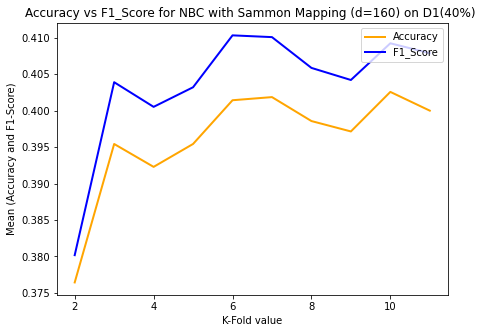

In [55]:
fig, ax = pyplot.subplots(figsize=(7,5))

ax.plot(folds, accList, color='orange', label="Accuracy", linewidth=2)
ax.plot(folds, fscoreList, color='blue', label="F1_Score", linewidth=2)
# ax.set_ylim(ymin=.3, ymax=.5)
ax.set_title('Accuracy vs F1_Score for NBC with Sammon Mapping (d=160) on D1(40%) ')
ax.set_xlabel('K-Fold value')
ax.set_ylabel('Mean (Accuracy and F1-Score)')
ax.legend(loc="upper right")

# show the plot
pyplot.show()